# Case Study 2: Which Fruit does Jerry Seinfeld look like?

We will be creating a neural network that can classify images of fruits, using an opensource dataset fron kaggle. Then since we can feed any image we want into the network, we will use them to find out which fruit Jerry Seinfeld looks like the most. We begin by downloading a large dataste from kaggle and processing the data into a pandas dataframe.

## Preprocessing the Data

Unfortunately the data is not in a particularly convienient format, in particular the images are not all the same size. We will need to resize the images to a standard size, which we have chosen as 100x100 pixels. While `tensorflow` does have support for this image modification, it might slow our network down considering the size of the dataset. Instead we will use the `PIL` library to resize the images and create a new file directory.

In [53]:
import os
from PIL import Image

# Define source and target directories
src_dir = 'MY_data'
target_dir = 'data'

# Loop over all subdirectories in the source directory
for dirpath, dirnames, filenames in os.walk(src_dir):
    for filename in filenames:
        if filename.endswith(".jpeg") or filename.endswith(".png"):  # Add or modify the conditions based on your image file types
            # Create target subdirectory if it doesn't exist
            target_subdir = os.path.join(target_dir, os.path.relpath(dirpath, src_dir))
            os.makedirs(target_subdir, exist_ok=True)
            # Open the image file
            img = Image.open(os.path.join(dirpath, filename))
            img = img.convert("RGB")
            # Resize the image
            img_resized = img.resize((100, 100))
            # Save the resized image to the target subdirectory
            img_resized.save(os.path.join(target_subdir, filename))

Thankfully the data came pre-split into training and testing data, and the classification of the images (fruits) are subdirectories in the training and test data respectively. The following code navigates the directories and creates a pandas dataframe with the image path and the classification of the image. Right now we have not rescaled the data at all, simply made it the same dimension, which while not ideal for classification with a neural network, it should still work!

In [54]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

'''
These dataframes contain the raw .jpeg data for each file, to allow for easy access to the network
'''

# Define the root directories
train_dir = 'data/train'
test_dir = 'data/test'

# Initialize lists to store file paths and labels
train_files = []
train_labels = []
test_files = []
test_labels = []

# Loop through each subdirectory in the train directory
for i, fruit_dir in enumerate(os.listdir(train_dir)):
    # Get the list of files in this directory
    files = os.listdir(os.path.join(train_dir, fruit_dir))
    # Append files and labels to the lists
    train_files.extend([os.path.join(train_dir, fruit_dir, f) for f in files])
    train_labels.extend(fruit_dir for _ in range(len(files)))

# Do the same for the test directory
for i, fruit_dir in enumerate(os.listdir(test_dir)):
    files = os.listdir(os.path.join(test_dir, fruit_dir))
    test_files.extend([os.path.join(test_dir, fruit_dir, f) for f in files])
    test_labels.extend(fruit_dir for _ in range(len(files)))

# Create dataframes
train_df = pd.DataFrame({'file': train_files, 'label': train_labels})
test_df = pd.DataFrame({'file': test_files, 'label': test_labels})

set_labels = list(set(train_labels))
print(set_labels)

['banana', 'cherry', 'avocado', 'watermelon', 'pinenapple', 'orange', 'kiwi', 'apple', 'strawberries', 'mango']


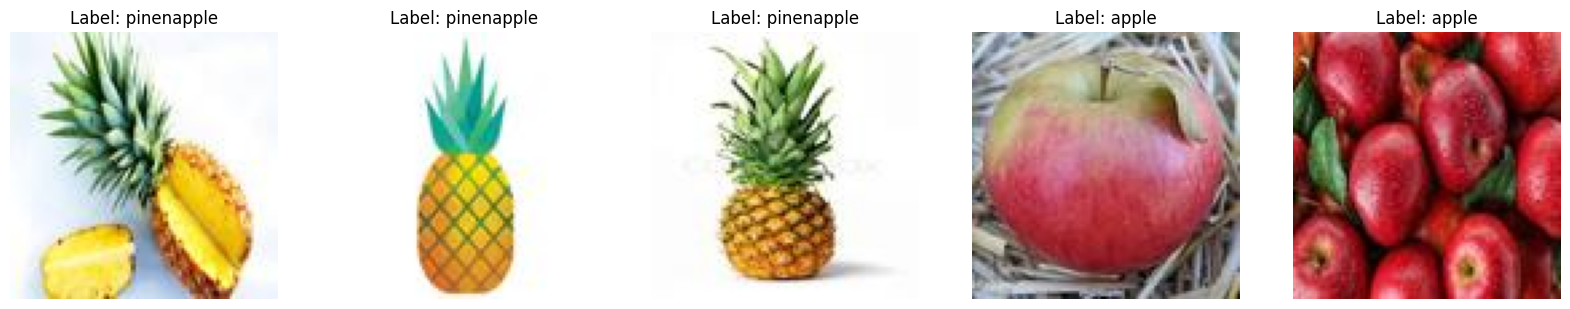

In [55]:

import matplotlib.pyplot as plt
from PIL import Image

def display_images(df, num_images):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))

    for i in range(num_images):
        file = df['file'][100*i]
        img = Image.open(file)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {df['label'][100*i]}")

    plt.show()

# Display the first 5 images in the DataFrame
display_images(train_df, 5)

Above we see a few low res versions of our images, this may have an impact on our network but we'll take the hit of resolution for dataset size.

## Training the Model

Important aspects are colour and distinct edges, which seem relatively preserved with image compression. Below we construct a neural network which takes in a 100x100 pixel image, which has a convolutional layer, a pooling layer, and a fully connected layer. We will train the model on our compressed training data with 10 epochs and a batch size of 32. We will then evaluate the model on the test data.

In [56]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Convert integer labels to string labels
train_df['label'] = train_df['label'].astype(str)

# Preprocess images
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='file',
    y_col='label',
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical') 

# Define model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))  

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','precision','recall'])

# Train model
model.fit(train_generator, epochs=10)

Found 2301 validated image filenames belonging to 10 classes.


Epoch 1/10


/home/et18646/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


 2/72 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.1562 - loss: 3.3120 - precision: 0.1042 - recall: 0.0391           

/home/et18646/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.1743 - loss: 4.5844 - precision: 0.1717 - recall: 0.0498
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.4315 - loss: 1.5978 - precision: 0.6917 - recall: 0.1424
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.6226 - loss: 1.1529 - precision: 0.8233 - recall: 0.3079
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.7612 - loss: 0.8332 - precision: 0.9026 - recall: 0.5210
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.8563 - loss: 0.5567 - precision: 0.9413 - recall: 0.7109
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.9135 - loss: 0.3773 - precision: 0.9647 - recall: 0.8342
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.9578 - loss: 0.2308 - precision: 0.9858 - recall: 0.9300
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.9813 - loss: 0.1480 - precision: 0.9929 - recall: 0.9706
Epoch 9/10
72/72 ━━━━━━━━━━━━━━━━━━

In my training, I reach an accuracy of 0.96 after 10 epochs, which is pretty impressive. Bare in mind we have quite a few processing layers for this, which we can try to reduce later on. Below are a few images of the model's predictions on the test data.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


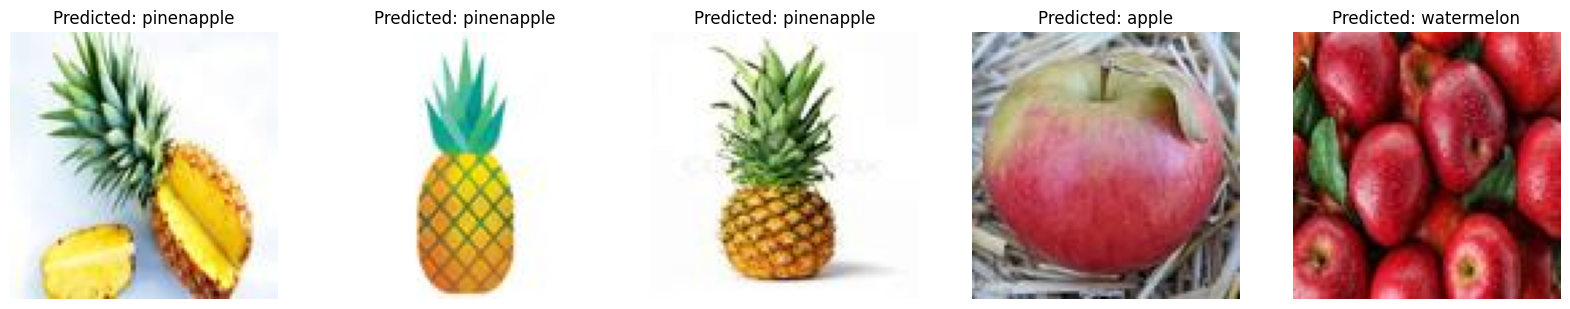

In [70]:
label_map = train_generator.class_indices 

def display_predictions(df, num_images):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))

    for i in range(num_images):
        file = df['file'][100*i]
        img = Image.open(file)
        img_array = np.array(img)
        img_array = img_array.reshape(1, 100, 100, 3)
        prediction = model.predict(img_array)
        predicted_index = np.argmax(prediction)


        for label, index in label_map.items():
            if index == predicted_index:
                predicted_label = label
                break

        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Predicted: {predicted_label}")

    plt.show()

# Display the first 5 predictions
display_predictions(train_df, 5)

As we can see there is a fairly understandable mislabelling of an apple as a watermelon there.

## What fruit is Jerry Seinfeld?

Now let's import the image of Jerry Seinfeld and see which fruit he looks like the most.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


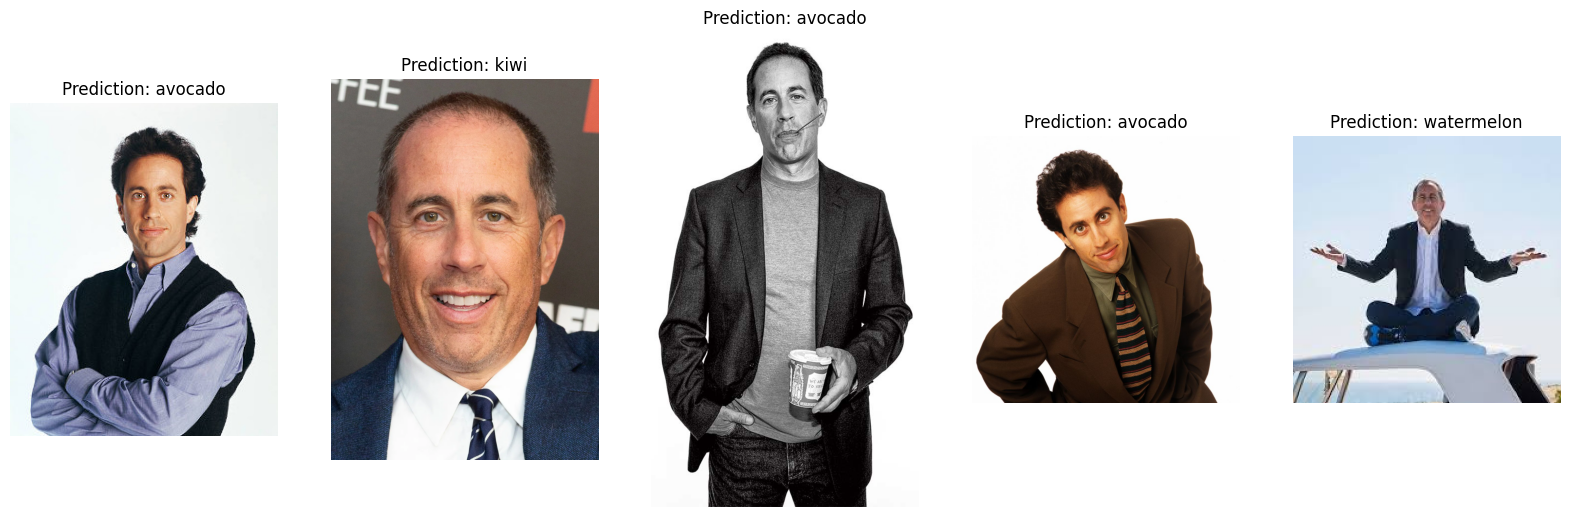

In [73]:

def display_images_with_predictions(files, model):
    fig, axes = plt.subplots(1, len(files), figsize=(20, 20))

    for i, file in enumerate(files):
        # Open and process image
        img = Image.open(file)
        img_resized = img.resize((100, 100))
        img_array = np.array(img_resized) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Make prediction
        prediction = model.predict(img_array)
        predicted_index = np.argmax(prediction)


        for label, index in label_map.items():
            if index == predicted_index:
                predicted_label = label
                break

        # Display image and prediction
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Prediction: {predicted_label}")

    plt.show()

# List of image files
files = ['jerry.jpg', 'jerry2.webp', 'jerry3.jpg','jerry4.jpg','jerry5.jpeg']

# Display images with predictions
display_images_with_predictions(files, model)


Some mixed results here on the fruit confirmation of Jerry Seinfeld. We seem to have a higher avocado to Jerry ratio, let's add some more layers to our neural network to see if we can get some more consistent results.

## Improving the Model

We will add another convolutional layer and pooling layer to our model, in the hopes that we can pin down more detail in his face. The below network took considerably longer (considering the size of the additional layers) so we limited our epochs to 6, in the hopes that the size of the training set is large enoguh to get a good result.

In [75]:

model2 = Sequential()
model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(64, (3, 3), activation='relu'))  
model2.add(MaxPooling2D((2, 2))) 
model2.add(Conv2D(128, (3, 3), activation='relu'))  
model2.add(MaxPooling2D((2, 2)))  
model2.add(Flatten())
model2.add(Dense(64, activation='relu'))
model2.add(Dense(10, activation='softmax'))

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','precision','recall'])

model2.fit(train_generator, epochs=6)

Epoch 1/6
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.1778 - loss: 2.1463 - precision: 0.2104 - recall: 0.0124
Epoch 2/6
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.4003 - loss: 1.5671 - precision: 0.5757 - recall: 0.1300
Epoch 3/6
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.4695 - loss: 1.3711 - precision: 0.6546 - recall: 0.2451
Epoch 4/6
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.5469 - loss: 1.2561 - precision: 0.6981 - recall: 0.3239
Epoch 5/6
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.6280 - loss: 1.0505 - precision: 0.7764 - recall: 0.4468
Epoch 6/6
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.6977 - loss: 0.8544 - precision: 0.8037 - recall: 0.5424


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


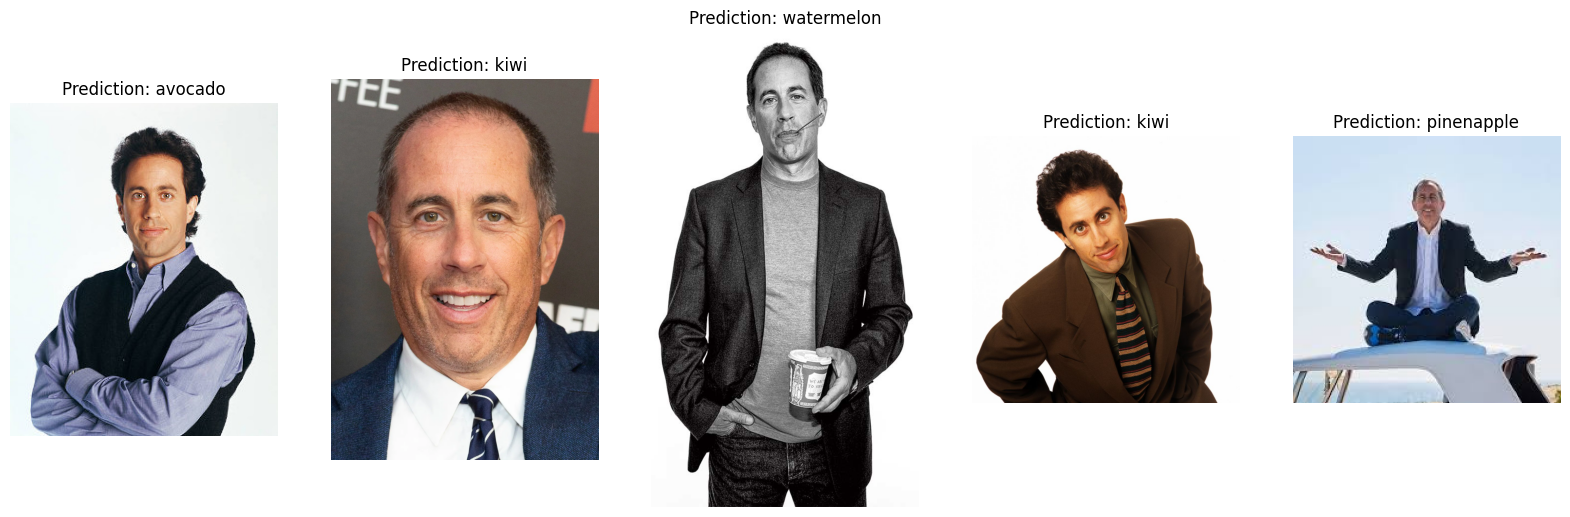

In [76]:
display_images_with_predictions(files, model2)


Oh no! Our results seem even more mixed than before! However notice that with 6 epochs we only reach 0.70 accuracy, which is significantly worse than our previous model. Strangely this is also a low lower accuracy than the original model with two less convolutionala and pooling layers, this might be an indicater that we're overfitting our data. Let's increase the number of epochs to see if we reach the same level of accuracy.

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.7306 - loss: 0.7945 - precision: 0.8236 - recall: 0.6142
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.7668 - loss: 0.6778 - precision: 0.8306 - recall: 0.6610
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.8376 - loss: 0.4988 - precision: 0.9022 - recall: 0.7769
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.8974 - loss: 0.3285 - precision: 0.9355 - recall: 0.8625
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.9314 - loss: 0.2399 - precision: 0.9543 - recall: 0.9095
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.9356 - loss: 0.1922 - precision: 0.9519 - recall: 0.9263
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.9266 - loss: 0.2104 - precision: 0.9409 - recall: 0.9153
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.9732 - loss: 0.1025 - precision: 0.9775 - recall: 0.9681
Epoch 9/10
72/72 ━━━━━━━

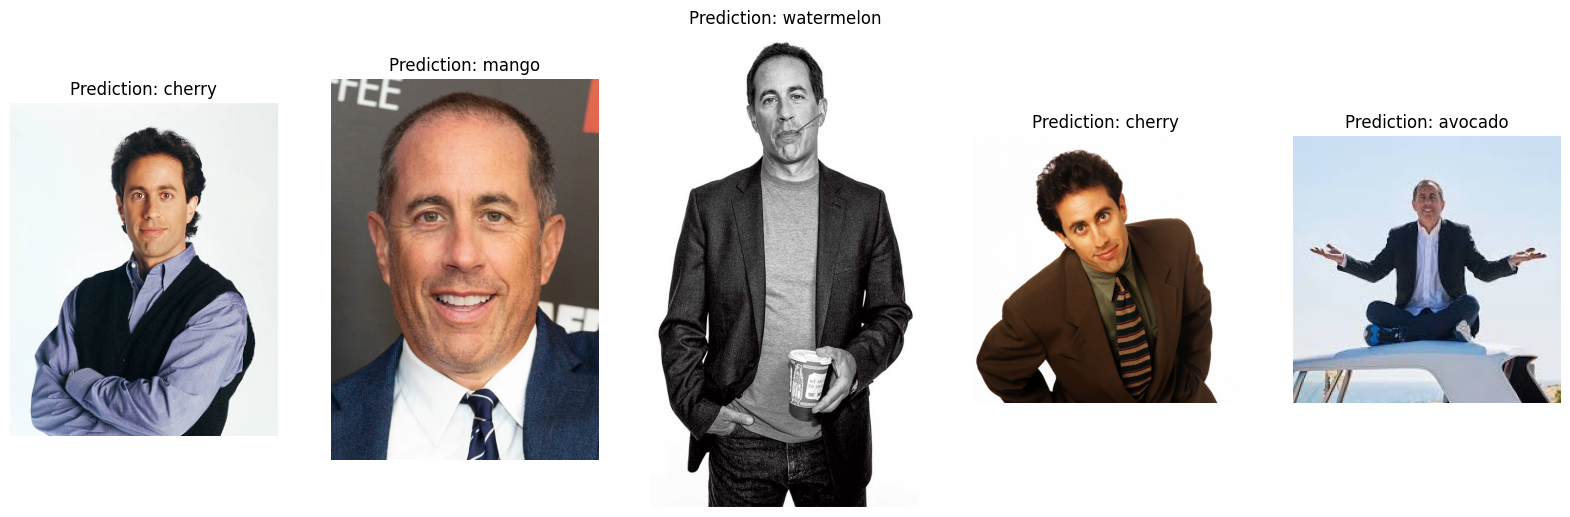

In [77]:

model2.fit(train_generator, epochs=10)

display_images_with_predictions(files, model2)

Again even with further epochs we see that we have very little consensus on which fruit he truly is. Considering increasing the number of epochs did not improve our accuracy, it's very likely we're overfitting the data - or a fruit classifier is not very well defined on human images. Let's assume the former and try to reduce the number of layers in our network and add some damping to see if we can get a more consistent result.

Below we have 2 convolutional layers, which are both pooled and flattened, we also added `kernel_regularizer` to our dense layer to try and reduce overfitting. 

Another technique to avoid overfitting, especially with classification of images, is to generate new images by rotating the original ones to help th enetwork generalise much better, fortunately this can be added as an argument to `train_datagen` in `ImageDataGenerator`. Below is an example of using this technique to generate new images.

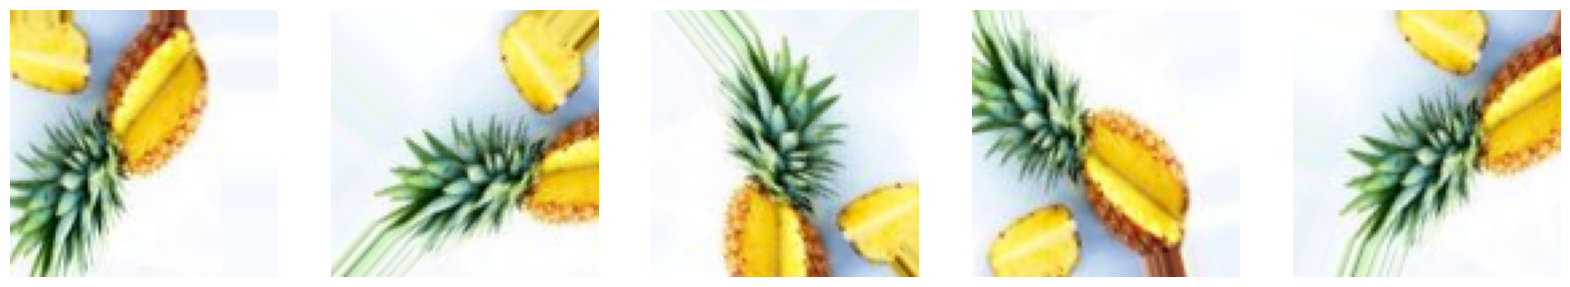

In [91]:
#Read and reshape the image
img = train_df['file'].iloc[0]
img = plt.imread(img)
img = img.reshape((1,) + img.shape)

#Create the deformation technique
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

#Create the image generator
img_generator = train_datagen.flow(img)

# Generate and plot the first 5 augmented images
plt.figure(figsize=(20, 10))
for i in range(5):
    batch = next(img_generator)
    image = batch[0]
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

Found 2301 validated image filenames belonging to 10 classes.
Epoch 1/6


/home/et18646/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/home/et18646/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.1613 - loss: 2.8371 - precision: 0.2635 - recall: 0.0038
Epoch 2/6
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.3511 - loss: 1.8946 - precision: 0.4986 - recall: 0.0675
Epoch 3/6
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.3730 - loss: 1.7839 - precision: 0.5757 - recall: 0.0885
Epoch 4/6
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.4136 - loss: 1.7063 - precision: 0.5692 - recall: 0.1167
Epoch 5/6
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.4212 - loss: 1.6482 - precision: 0.6225 - recall: 0.1494
Epoch 6/6
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.4546 - loss: 1.5974 - precision: 0.6633 - recall: 0.1729
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


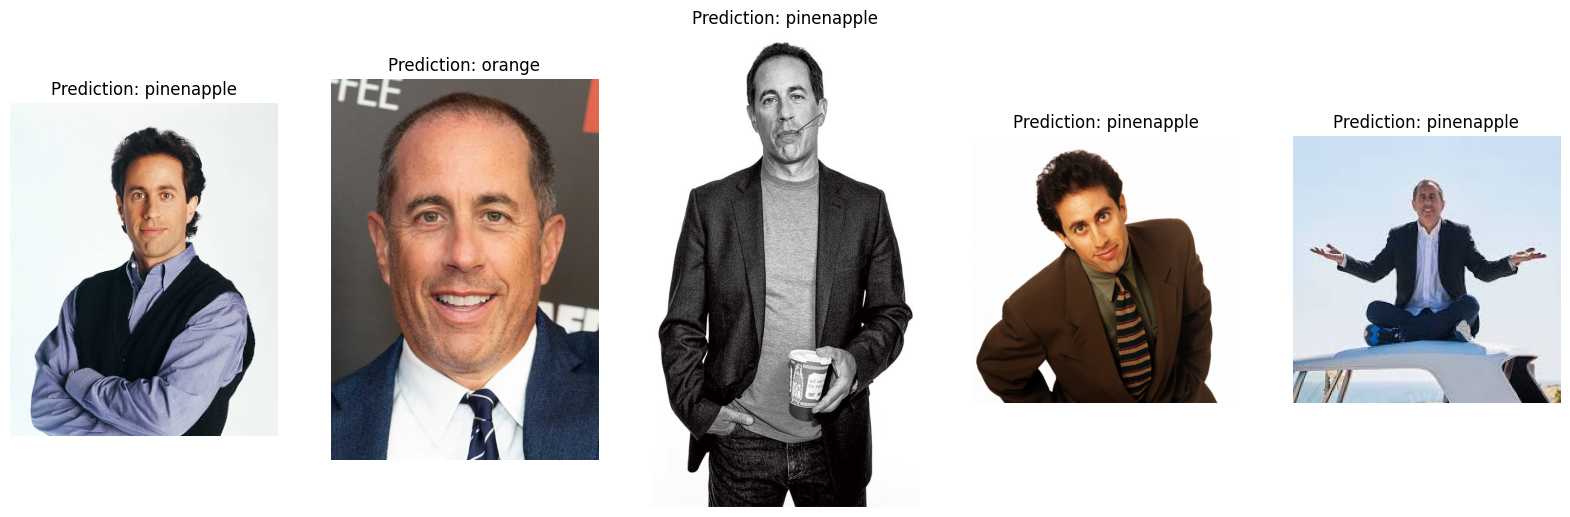

In [92]:
from keras import regularizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='file',
    y_col='label',
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical'
)

model3 = Sequential()
model3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model3.add(MaxPooling2D((2, 2)))
model3.add(Conv2D(32, (3, 3), activation='relu'))  
model3.add(MaxPooling2D((2, 2)))  
model3.add(Flatten())
model3.add(Dense(64,kernel_regularizer=regularizers.l2(0.01),activation='relu'))
model3.add(Dense(10, activation='softmax'))

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','precision','recall'])

model3.fit(train_generator,epochs=6)


display_images_with_predictions(files, model3)

Unfortunately we still have so consensus, it's very possible that Jerry Seinfeld is not any kind of fruit or vegetable. Finally we finish by attempting to classify the same image of jerry seinfeld but with our deformed images aimed for training purposes.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


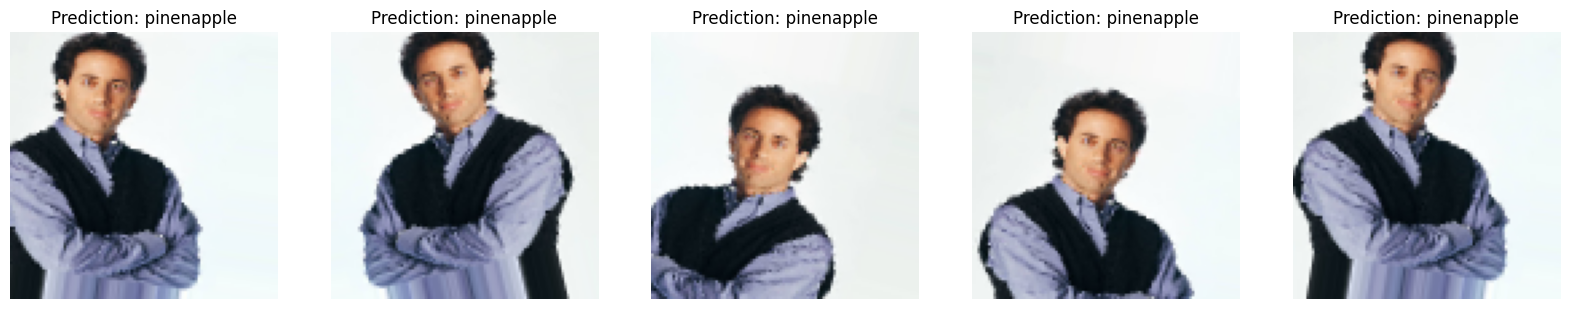

In [93]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load and preprocess the image
img = load_img('jerry.jpg', target_size=(100, 100))  # Adjust target_size to match your model's input shape
img = img_to_array(img)
img = np.expand_dims(img, axis=0)

# Create a generator for the image
img_generator = train_datagen.flow(img)

# Generate and plot the first 5 augmented images
plt.figure(figsize=(20, 10))
for i in range(5):
    batch = next(img_generator)
    image = batch[0]
    prediction = model3.predict(np.expand_dims(image, axis=0))
    predicted_index = np.argmax(prediction)
    for label, index in label_map.items():
        if index == predicted_index:
            predicted_label = label
            break
    plt.subplot(1, 5, i+1)
    plt.imshow(image)  # Scale the image values back to [0-1] range for correct display
    plt.title(f'Prediction: {predicted_label}')
    plt.axis('off')
plt.show()

Hey, that's pretty good! At least it works for the same source image.